In [1]:
import numpy as np
import pandas as pd
import matplotlib  
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
import seaborn
%matplotlib inline 

In [2]:
nyc_data = pd.read_csv('yellow_tripdata_2015-06.csv', nrows=1000000, parse_dates=[1,2])

#### Data Columns

In [3]:
nyc_data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [4]:
nyc_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30
2,2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,-73.978111,40.738434,1,N,-73.990273,40.745438,1,8.0,0.0,0.5,2.20,0.0,0.3,11.00
3,2,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,-73.945892,40.773529,1,N,-73.971527,40.760330,1,13.5,0.0,0.5,2.86,0.0,0.3,17.16
4,1,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,-73.979088,40.776772,1,N,-73.982162,40.758999,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30


In [ ]:
# Fancy data plotting. Uncomment the following

# plt.style.use = 'default' #Better Styling  
# new_style = {'grid': False} #Remove grid  
# matplotlib.rc('axes', **new_style)  
# from matplotlib import rcParams  
# rcParams['figure.figsize'] = (17.5, 17) #Size of figure  
# rcParams['figure.dpi'] = 250

# # P.set_axis_bgcolor('black') #Background Color

# P=nyc_data.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',color='black',xlim=(-74.06,-73.77),ylim=(40.61, 40.91),s=.02,alpha=.6)
# P.set_axis_bgcolor('white')

In [5]:
# Drop column with payment type 2 since all rows with this row have 0 tip amount
nyc_data = nyc_data.drop(nyc_data[nyc_data.payment_type == 2].index)

# Create additional features to do some EDA
nyc_data['tip_per_total'] = nyc_data['tip_amount'] / nyc_data['total_amount']
nyc_data['tip_per_distance'] = nyc_data['tip_amount'] / nyc_data['trip_distance']
nyc_data['trip_duration'] = nyc_data['tpep_dropoff_datetime'] - nyc_data['tpep_pickup_datetime']
nyc_data['trip_seconds'] = nyc_data.trip_duration.apply(lambda x: x.seconds)
nyc_data['tip_per_duration'] = nyc_data['tip_amount'] / nyc_data['trip_seconds']
nyc_data['weekday'] = nyc_data['tpep_pickup_datetime'].apply(lambda x: x.strftime("%A"))
nyc_data['pickup_hour'] = nyc_data['tpep_pickup_datetime'].apply(lambda x: x.hour)

# Drop Rows where some columns are 0 cause they will skew the results
nyc_data = nyc_data.drop(nyc_data[nyc_data.tip_per_total == 0.0].index)
nyc_data = nyc_data.drop(nyc_data[nyc_data.trip_seconds == 0.0].index)
nyc_data = nyc_data.drop(nyc_data[nyc_data.trip_distance == 0.0].index)

In [14]:
weekday_hour_group = nyc_data.groupby(['weekday', 'pickup_hour']).mean()

##### EDA plots

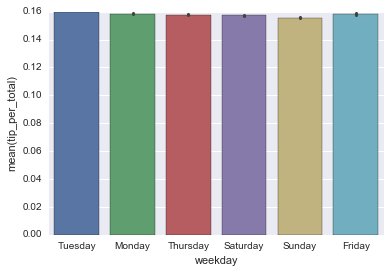

In [12]:
seaborn.barplot(x=nyc_data.weekday, y=nyc_data.tip_per_total)

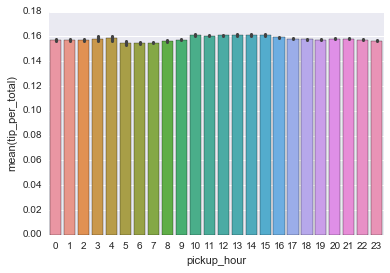

In [8]:
seaborn.barplot(x=nyc_data.pickup_hour, y=nyc_data.tip_per_total)

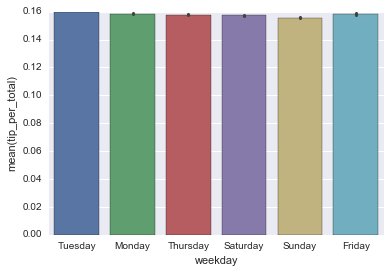

In [9]:
seaborn.barplot(x=nyc_data.weekday, y=nyc_data.tip_per_total)

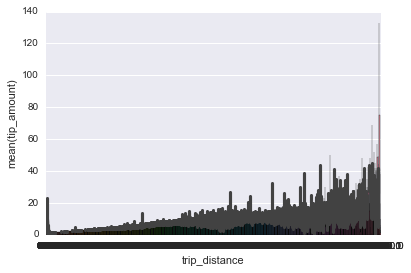

In [13]:
seaborn.barplot(x=nyc_data.trip_distance, y=nyc_data.tip_amount)

In [17]:
seaborn.barplot(x=weekday_hour_group.weekday'=='Friday', y=weekday_hour_group.tip_per_total)

SyntaxError: invalid syntax (<ipython-input-17-499d9a2da7ff>, line 1)

In [21]:
weekday_hour_group.reset_index(inplace=True)

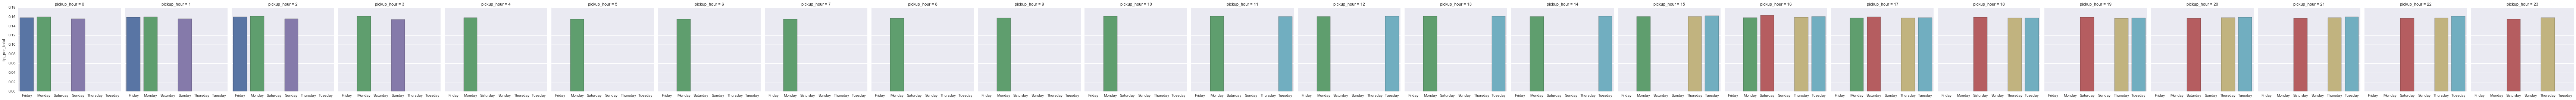

In [24]:
fg = seaborn.factorplot(x='weekday', y='tip_per_total', 
                        col='pickup_hour', data=weekday_hour_group, kind='bar')
fg.set_xlabels('')

Things to do in order to solve the problem which areas of NY pay the highest tips
1. Merge Community District Name with the above Data frame
2. Aggregate info per Community District and check out if the mean values of some districts are significantly greater than others

In [ ]:
shp = fiona.open('Feb6_Revised_Shape_file/NYC_Feb6.shp')
coords = shp.bounds
shp.close
print(coords)
w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

In [ ]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h))

_out = m.readshapefile('Feb6_Revised_Shape_file/NYC_Feb6', name='nyc', drawbounds=False, color='none', zorder=2)